In [2]:
import random, cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from typing import Union

In [3]:
def pick_random_images(root_dir: Union[str, Path], n: int, exts=(".jpg", ".jpeg", ".png")):
    root = Path(root_dir)
    if not root.exists():
        raise FileNotFoundError(root)

    pool = [p for p in root.rglob('*') if p.suffix.lower() in exts]
    if not pool:
        raise RuntimeError(f"No images with extensions {exts} under {root}")

    random.shuffle(pool)
    return pool[: min(n, len(pool))]


In [5]:
pick_random_images("teczowka_data", 5)

[WindowsPath('teczowka_data/017/IMG_017_L_5.JPG'),
 WindowsPath('teczowka_data/018/IMG_018_R_1.JPG'),
 WindowsPath('teczowka_data/014/IMG_014_R_1.JPG'),
 WindowsPath('teczowka_data/003/IMG_003_R_2.JPG'),
 WindowsPath('teczowka_data/029/IMG_029_L_3.JPG')]

In [46]:
def grayscale(img):
    if img.ndim == 2:
        return img
    weights = np.array([0.114, 0.587, 0.299])
    return (img[..., :3] @ weights).astype(np.uint8)

def binarize(gray, factor):
    thr = gray.mean() / factor
    return (gray < thr).astype(np.uint8) * 255

def _logical_shift(img_bool: np.ndarray, dy: int, dx: int) -> np.ndarray:
    """Return a view of img_bool shifted by (dy,dx) with zero padding."""
    h, w = img_bool.shape
    # y slice
    if dy < 0:
        ys = slice(0, h + dy)
        yt = slice(-dy, h)
    elif dy > 0:
        ys = slice(dy, h)
        yt = slice(0, h - dy)
    else:
        ys = yt = slice(0, h)
    # x slice
    if dx < 0:
        xs = slice(0, w + dx)
        xt = slice(-dx, w)
    elif dx > 0:
        xs = slice(dx, w)
        xt = slice(0, w - dx)
    else:
        xs = xt = slice(0, w)

    out = np.zeros_like(img_bool)
    out[yt, xt] = img_bool[ys, xs]
    return out

def dilatation(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    fg = (img == 255)
    ky, kx = np.where(kernel == 1)
    cy, cx = kernel.shape[0] // 2, kernel.shape[1] // 2
    acc = np.zeros_like(fg)
    for dy, dx in zip(ky - cy, kx - cx):
        acc |= _logical_shift(fg, dy, dx)
    return acc.astype(np.uint8) * 255

def erosion(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    fg = (img == 255)
    ky, kx = np.where(kernel == 1)
    cy, cx = kernel.shape[0] // 2, kernel.shape[1] // 2
    acc = np.ones_like(fg)
    for dy, dx in zip(ky - cy, kx - cx):
        acc &= _logical_shift(fg, dy, dx)
    return acc.astype(np.uint8) * 255

def opening(mask, k):
    return dilatation(erosion(mask, k), k)

def closing(mask, k):
    return erosion(dilatation(mask, k), k)

def largest_connected_component(bin_img):
    h, w = bin_img.shape
    visited = np.zeros_like(bin_img, dtype=bool)
    labels  = np.zeros_like(bin_img, dtype=bool)
    best_sz = 0; best_mask = None
    stack = []

    for y, x in zip(*np.where(bin_img)):
        if visited[y, x]:
            continue
        cur_mask = []
        stack.append((y, x)); visited[y, x] = True
        while stack:
            cy, cx = stack.pop(); cur_mask.append((cy, cx))
            for dy in (-1, 0, 1):
                for dx in (-1, 0, 1):
                    ny, nx = cy + dy, cx + dx
                    if 0 <= ny < h and 0 <= nx < w and not visited[ny, nx] and bin_img[ny, nx]:
                        visited[ny, nx] = True; stack.append((ny, nx))
        if len(cur_mask) > best_sz:
            best_sz = len(cur_mask)
            best_mask = cur_mask
    mask = np.zeros_like(bin_img, dtype=bool)
    if best_mask is not None:
        ys, xs = zip(*best_mask)
        mask[ys, xs] = True

    return mask

def pad(image, pad_h, pad_w, pad_value=0):
    h, w = image.shape
    out = np.full((h + 2*pad_h, w + 2*pad_w), pad_value, dtype=image.dtype)
    out[pad_h:pad_h+h, pad_w:pad_w+w] = image
    return out

def extract_contour(binary, se):
    # ensure binary is 0/1
    A = (binary > 0).astype(np.uint8)
    B = (se > 0)
    sh, sw = B.shape
    ph, pw = sh//2, sw//2

    # 1) pad original for erosion
    padded = pad(A, ph, pw, pad_value=0)

    # 2) erosion: A_erosion[p] = 1 iff all B==1 positions fit inside A
    eroded = np.zeros_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            window = padded[i:i+sh, j:j+sw]
            if np.all(window[B] == 1):
                eroded[i, j] = 1

    # 3) contour = A - eroded(A)
    contour = A - eroded

    # scale back to 0/255
    return (contour * 255).astype(np.uint8)


In [33]:
list(Path("teczowka_kolory/te_ok").rglob("*"))

[WindowsPath('teczowka_kolory/te_ok/IMG_026_L_2.JPG'),
 WindowsPath('teczowka_kolory/te_ok/IMG_028_L_1.JPG'),
 WindowsPath('teczowka_kolory/te_ok/IMG_034_R_2.JPG'),
 WindowsPath('teczowka_kolory/te_ok/IMG_041_R_6.JPG'),
 WindowsPath('teczowka_kolory/te_ok/IMG_076_L_1.JPG')]

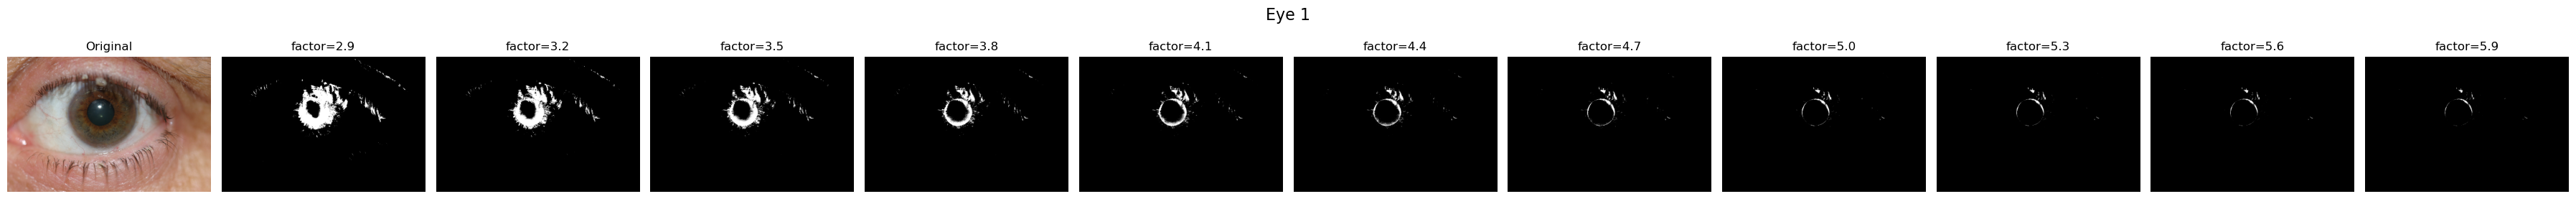

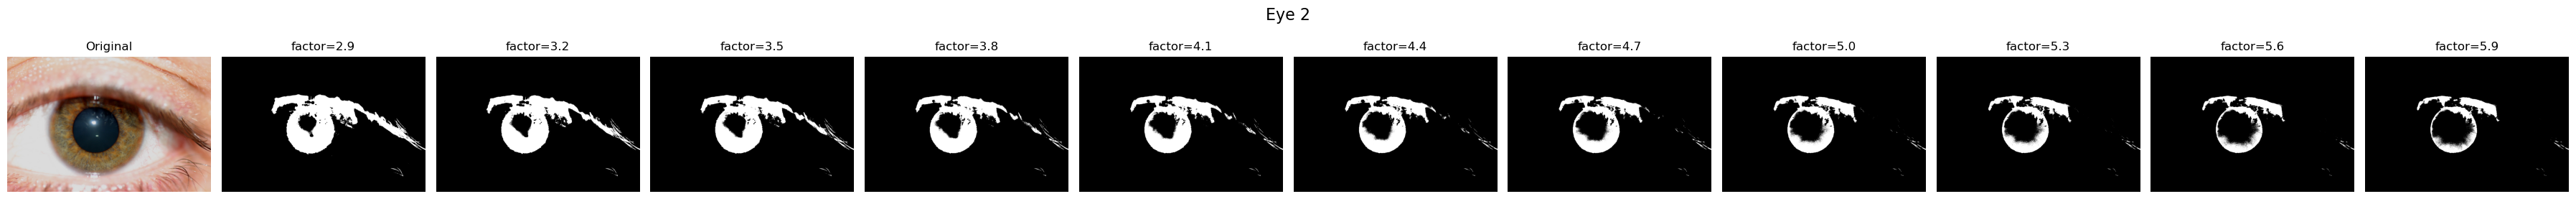

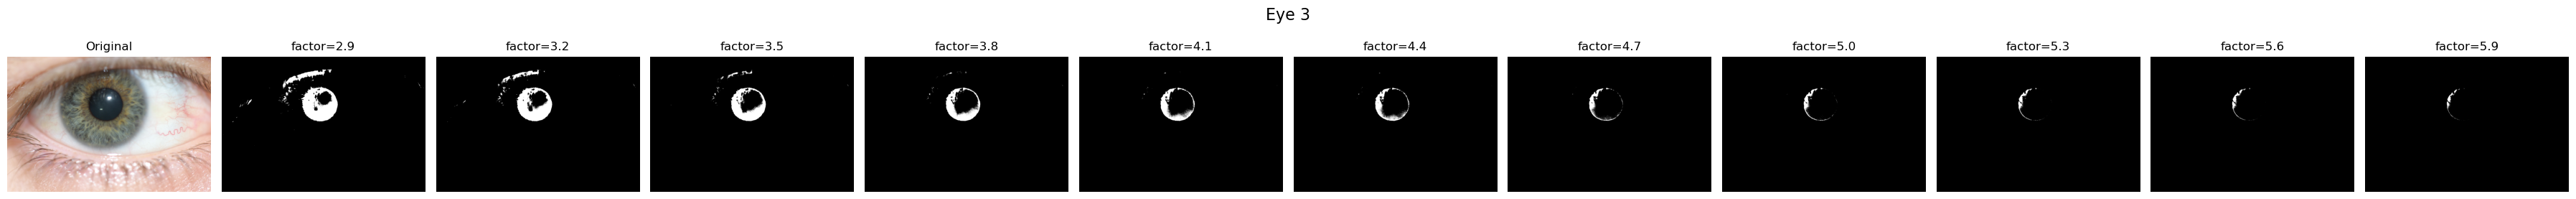

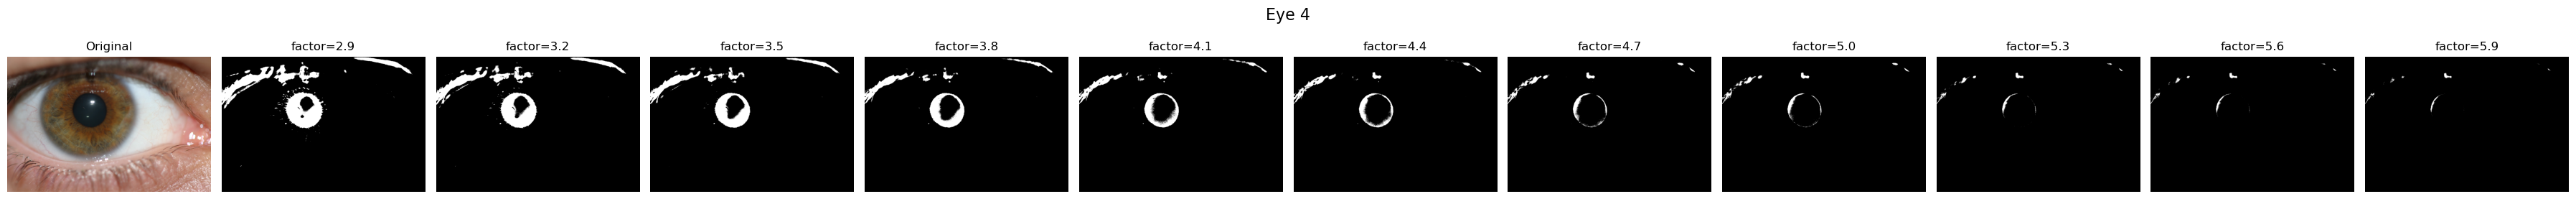

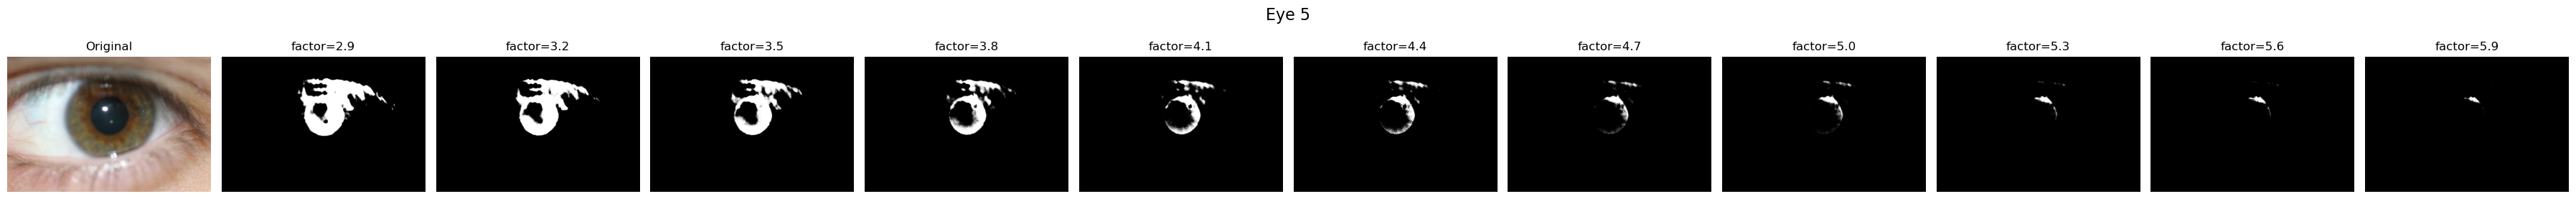

In [34]:
# image_paths = pick_random_images("teczowka_kolory/niebieski_zielony", 5)
# get all photos from folder: "teczowka_kolory/te_ok"
image_paths = list(Path("teczowka_kolory/te_ok").rglob("*"))

factors = [i/10 for i in range(29, 60, 3)]

for idx, path in enumerate(image_paths, 1):
    if not Path(path).exists():
        print(f"Warning: {path} not found – skipping")
        continue

    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = grayscale(rgb)

    num_pictures = len(factors) + 1
    fig, axes = plt.subplots(1, num_pictures, figsize=(3 * num_pictures, 3))
    axes[0].imshow(rgb); axes[0].set_title("Original"); axes[0].axis("off")

    for j, f in enumerate(factors, 1):
        mask = binarize(gray, f)
        axes[j].imshow(mask, cmap='gray')
        axes[j].set_title(f"factor={f}")
        axes[j].axis("off")

    fig.suptitle(f"Eye {idx}", fontsize=16)
    plt.tight_layout()
    plt.show()

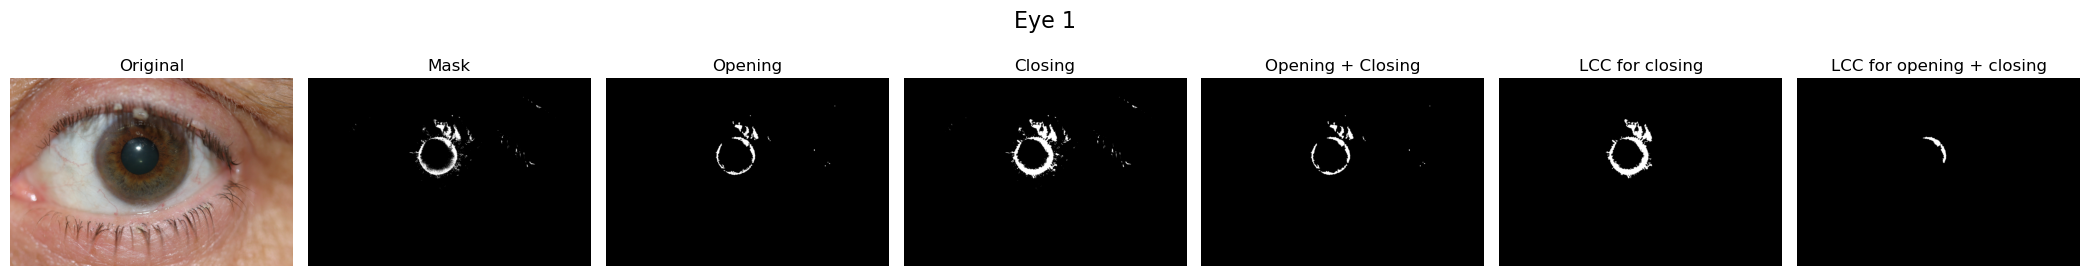

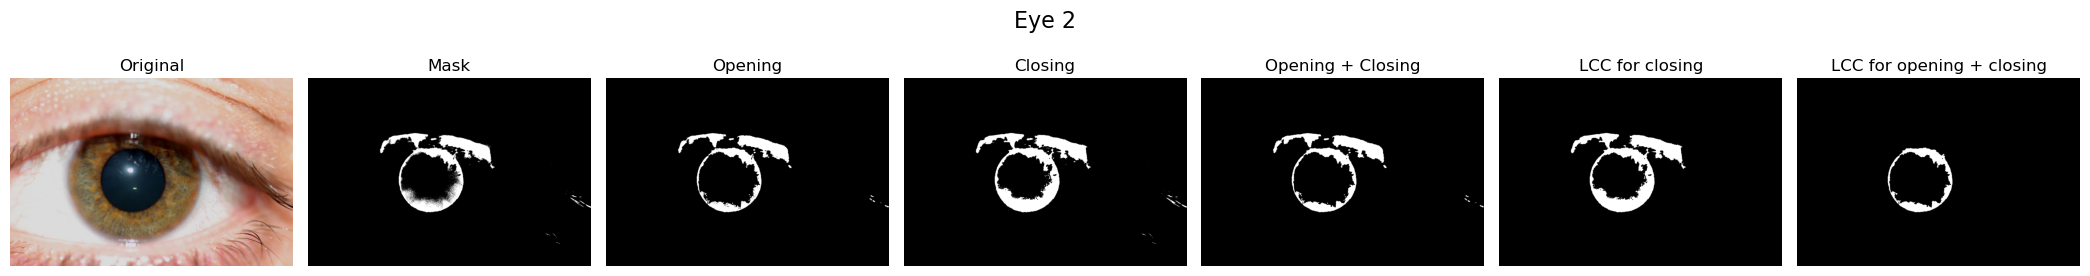

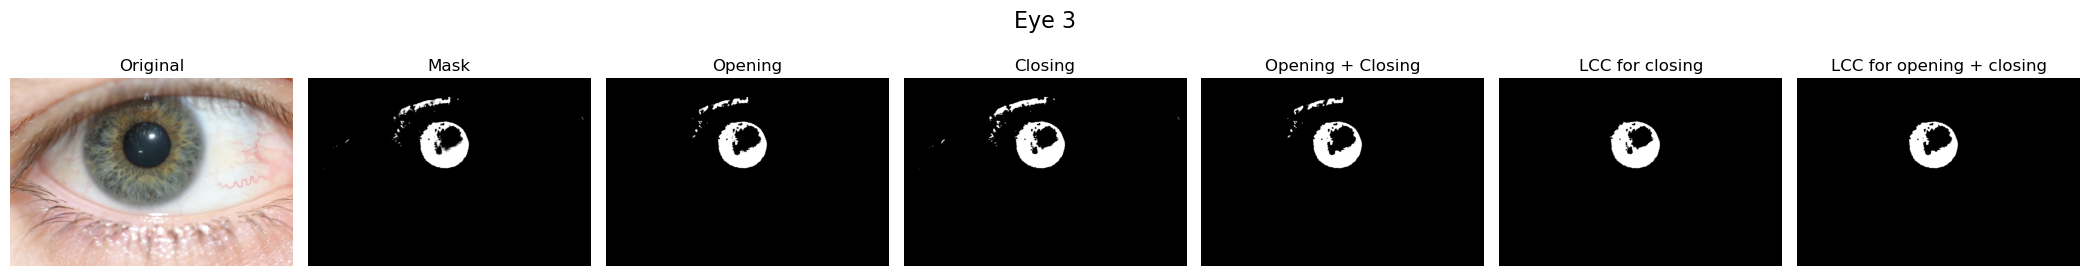

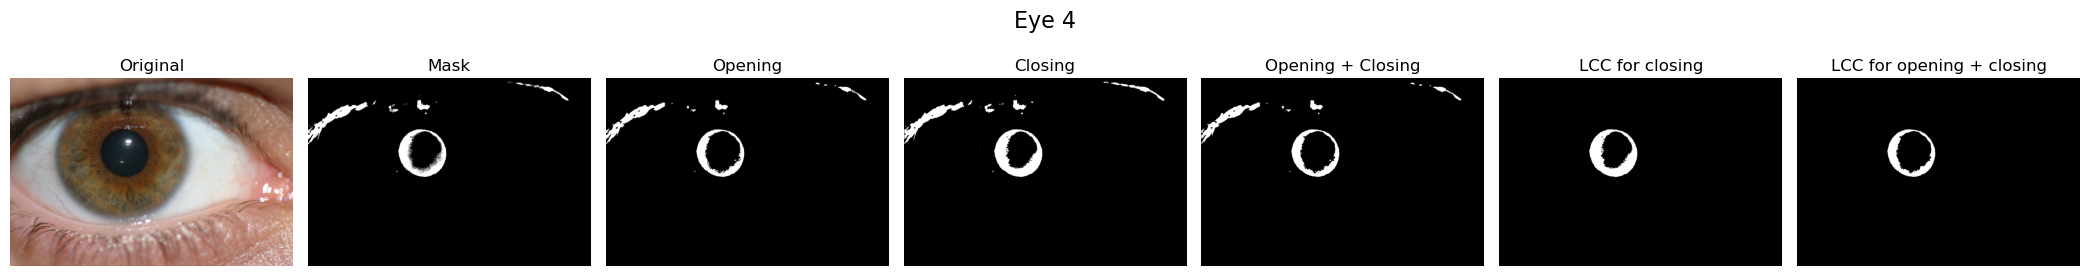

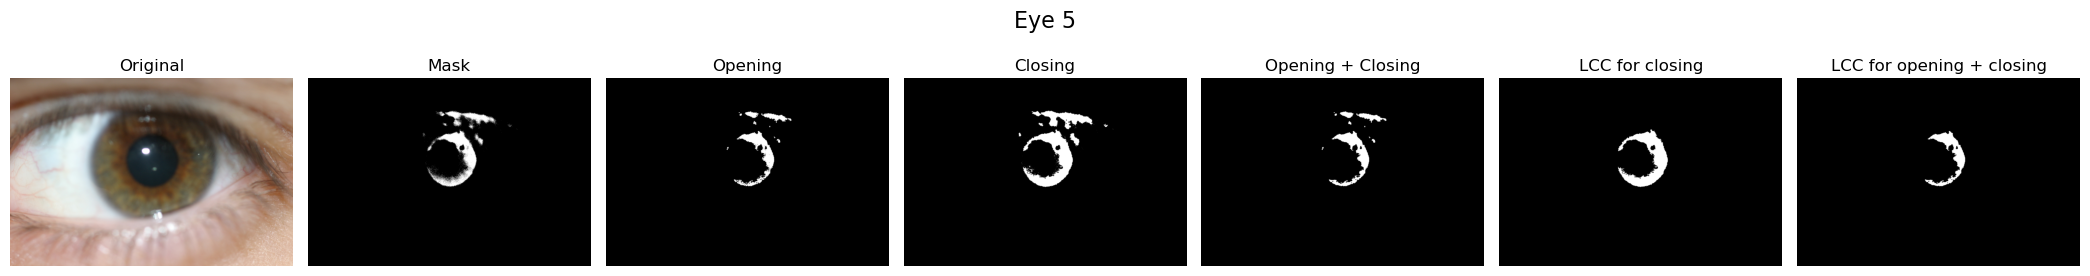

In [37]:
selected_factors = [4.1, 5.9, 3.2, 4.1, 4.1]

for idx, path in enumerate(image_paths, 1):
    if not Path(path).exists():
        print(f"Warning: {path} not found – skipping")
        continue

    factor = selected_factors[idx - 1]

    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = grayscale(rgb)
    mask = binarize(gray, factor)

    num_pictures = 7
    fig, axes = plt.subplots(1, num_pictures, figsize=(3 * num_pictures, 3))
    axes[0].imshow(rgb); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(mask, cmap='gray'); axes[1].set_title("Mask"); axes[1].axis("off")
    axes[2].imshow(opening(mask, np.ones((5, 5))), cmap='gray'); axes[2].set_title("Opening"); axes[2].axis("off")
    axes[3].imshow(closing(mask, np.ones((5, 5))), cmap='gray'); axes[3].set_title("Closing"); axes[3].axis("off")
    axes[4].imshow(closing(opening(mask, np.ones((5, 5))), np.ones((5, 5))), cmap='gray'), axes[4].set_title("Opening + Closing"); axes[4].axis("off")
    axes[5].imshow(largest_connected_component(closing(mask, np.ones((5, 5)))), cmap='gray'), axes[5].set_title("LCC for closing"); axes[5].axis("off")
    axes[6].imshow(largest_connected_component(closing(opening(mask, np.ones((5, 5))), np.ones((5, 5)))), cmap='gray'), axes[6].set_title("LCC for opening + closing"); axes[6].axis("off")

    fig.suptitle(f"Eye {idx}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [38]:
def refine_circle_and_score(bin_mask: np.ndarray):
    if bin_mask.ndim != 2:
        raise ValueError("binary mask must be 2‑D")

    fg = bin_mask // 255
    if fg.sum() == 0:
        h, w = bin_mask.shape
        return np.zeros((h, w), dtype=np.uint8), 0.0

    # centre via projections (same method as UI)
    proj_y = np.sum(fg, axis=1)
    rows = np.where(proj_y > 0)[0]
    proj_x = np.sum(fg, axis=0)
    cols = np.where(proj_x > 0)[0]
    cy = (rows[0] + rows[-1]) // 2
    cx = (cols[0] + cols[-1]) // 2
    ry = (rows[-1] - rows[0]) / 2.0
    rx = (cols[-1] - cols[0]) / 2.0
    r  = (ry + rx) / 2.0

    # build ideal circle mask (NumPy broadcasting)
    h, w = bin_mask.shape
    yy, xx = np.ogrid[:h, :w]
    circle = ((xx - cx) ** 2 + (yy - cy) ** 2) <= r ** 2
    ideal = circle.astype(np.uint8) * 255

    # Jaccard score (intersection / union)
    inter = np.logical_and(fg, circle).sum()
    union = np.logical_or(fg, circle).sum()
    score = inter / union if union else 0.0

    return ideal, score

In [41]:
for idx, path in enumerate(image_paths, 1):
    if not Path(path).exists():
        print(f"Warning: {path} not found – skipping")
        continue

    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = grayscale(rgb)
    mask = binarize(gray, selected_factors[idx - 1])

    mask_closing = closing(mask, np.ones((5, 5)))
    mask_closing_opening = opening(mask_closing, np.ones((5, 5)))
    mask_opening = opening(mask, np.ones((5, 5)))
    mask_opening_closing = closing(mask_opening, np.ones((5, 5)))

    mask_closing_llc = largest_connected_component(mask_closing)
    mask_closing_opening_llc = largest_connected_component(mask_closing_opening)
    mask_opening_llc = largest_connected_component(mask_opening)
    mask_opening_closing_llc = largest_connected_component(mask_opening_closing)

    all_masks = {
        "mask_closing": mask_closing,
        "mask_closing_opening": mask_closing_opening,
        "mask_opening": mask_opening,
        "mask_opening_closing": mask_opening_closing,
        "mask_closing_llc": mask_closing_llc,
        "mask_closing_opening_llc": mask_closing_opening_llc,
        "mask_opening_llc": mask_opening_llc,
        "mask_opening_closing_llc": mask_opening_closing_llc
    }

    for name, mask in all_masks.items():
        _, score = refine_circle_and_score(mask)
        all_masks[name] = (mask, score)

    print(max([score for _, score in all_masks.values()]))
    print(max(all_masks, key=lambda x: all_masks[x][1]))

0.06825596167813618
mask_closing_opening
0.10656265894139605
mask_closing_opening
0.2887833969676726
mask_opening_closing
0.053696536658868387
mask_closing
0.2612178025386089
mask_closing_opening


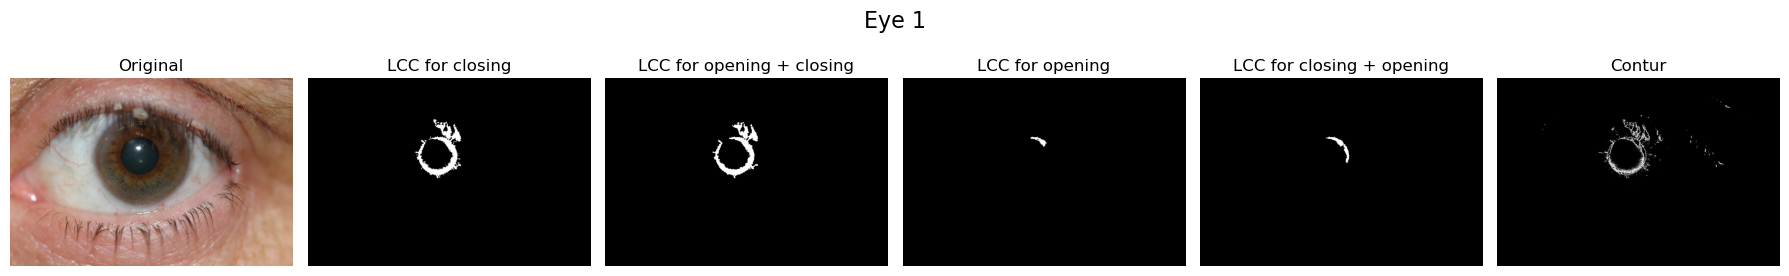

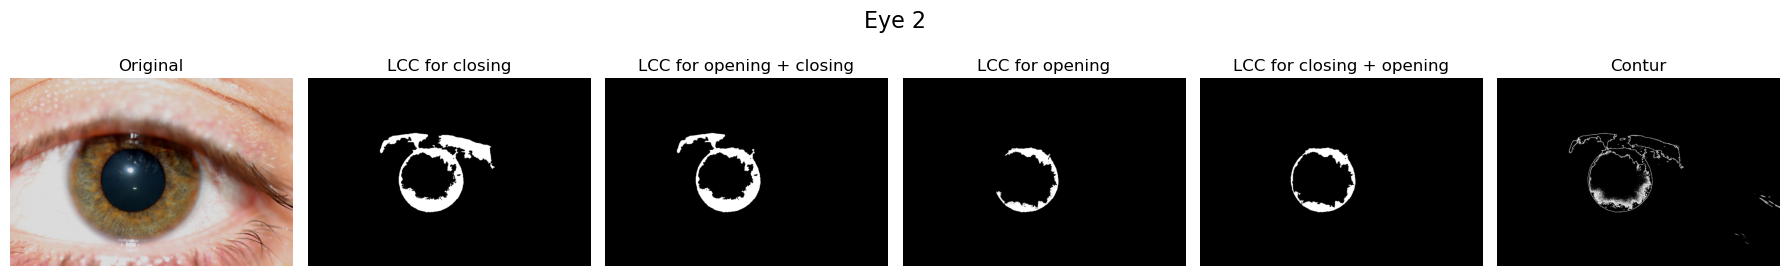

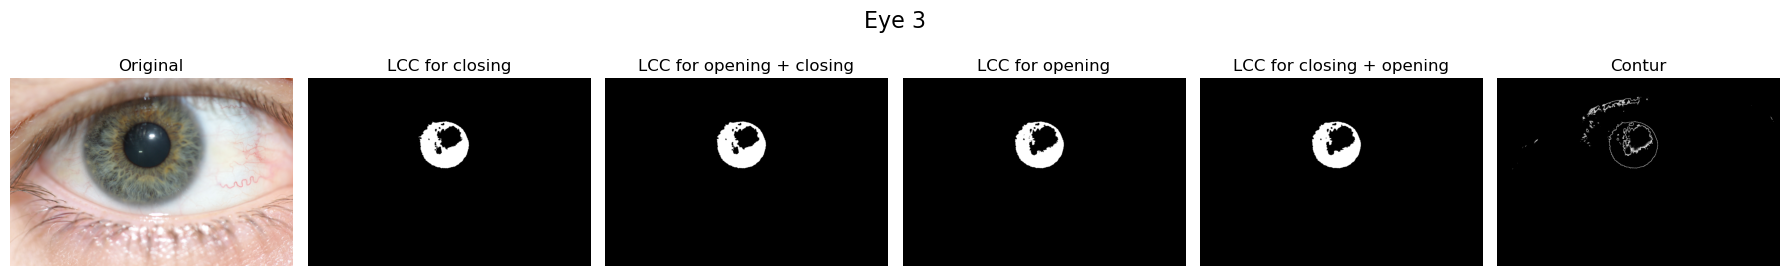

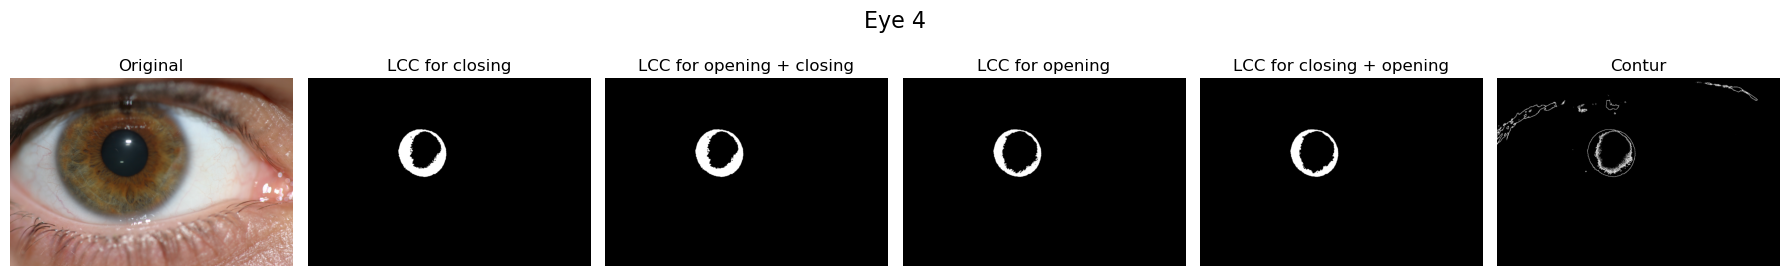

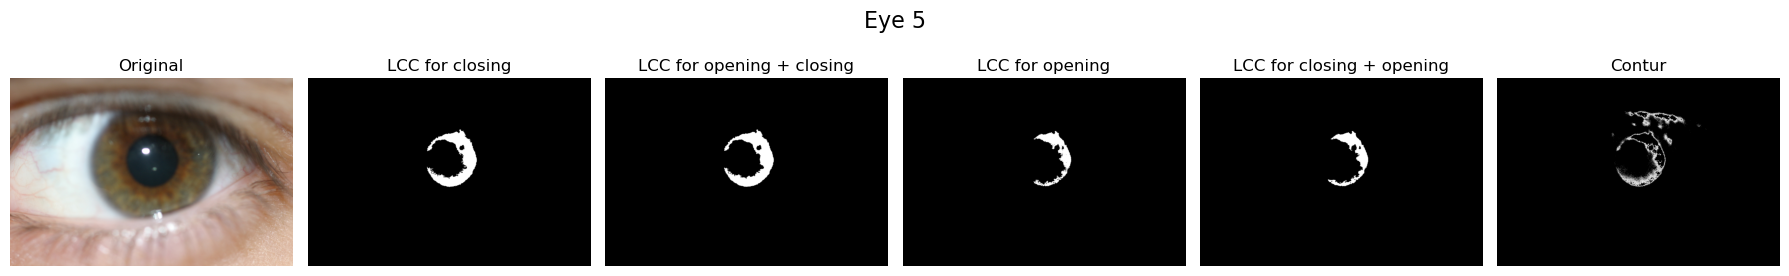

In [47]:
selected_factors = [4.1, 5.9, 3.2, 4.1, 4.1]

for idx, path in enumerate(image_paths, 1):
    if not Path(path).exists():
        print(f"Warning: {path} not found – skipping")
        continue

    factor = selected_factors[idx - 1]

    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = grayscale(rgb)
    mask = binarize(gray, factor)

    mask_closing = closing(mask, np.ones((5, 5)))
    mask_closing_opening = opening(mask_closing, np.ones((5, 5)))
    mask_opening = opening(mask, np.ones((5, 5)))
    mask_opening_closing = closing(mask_opening, np.ones((5, 5)))

    mask_closing_llc = largest_connected_component(mask_closing)
    mask_closing_opening_llc = largest_connected_component(mask_closing_opening)
    mask_opening_llc = largest_connected_component(mask_opening)
    mask_opening_closing_llc = largest_connected_component(mask_opening_closing)

    num_pictures = 6
    fig, axes = plt.subplots(1, num_pictures, figsize=(3 * num_pictures, 3))
    axes[0].imshow(rgb); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(mask_closing_llc, cmap='gray'); axes[1].set_title("LCC for closing"); axes[1].axis("off")
    axes[2].imshow(mask_closing_opening_llc, cmap='gray'); axes[2].set_title("LCC for opening + closing"); axes[2].axis("off")
    axes[3].imshow(mask_opening_llc, cmap='gray'); axes[3].set_title("LCC for opening"); axes[3].axis("off")
    axes[4].imshow(mask_opening_closing_llc, cmap='gray'); axes[4].set_title("LCC for closing + opening"); axes[4].axis("off")
    axes[5].imshow(extract_contour(mask, np.ones((5, 5))), cmap='gray'); axes[5].set_title("Contur"); axes[5].axis("off")

    fig.suptitle(f"Eye {idx}", fontsize=16)
    plt.tight_layout()
    plt.show()

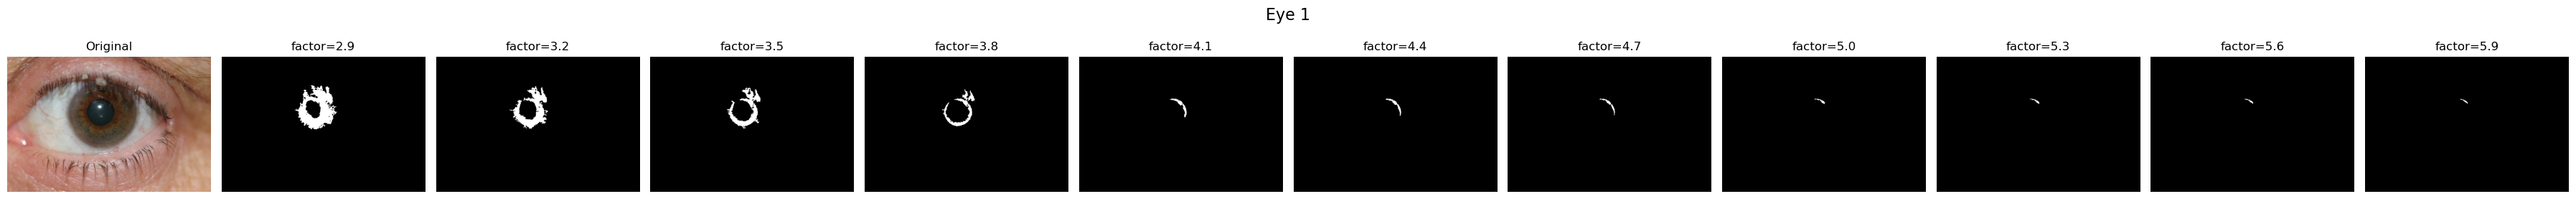

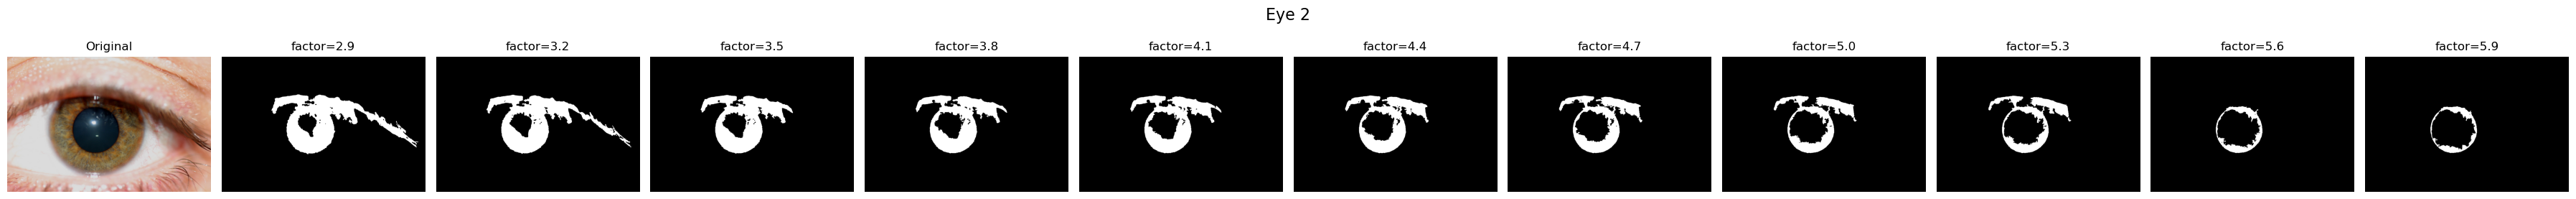

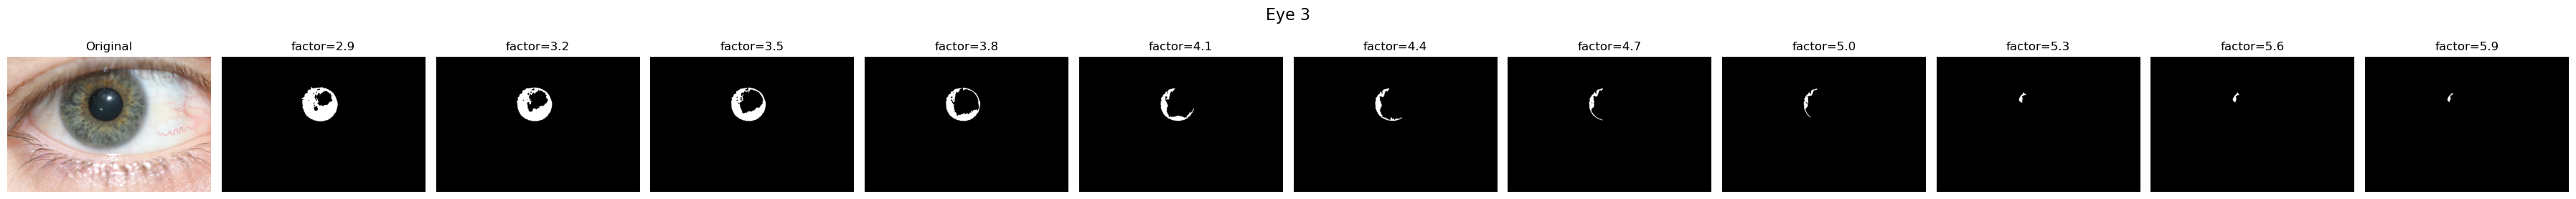

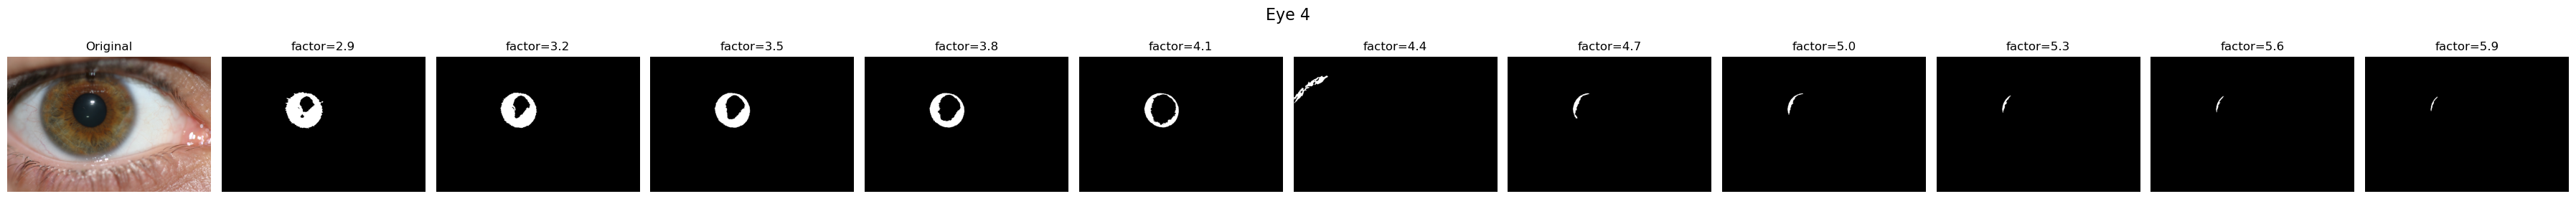

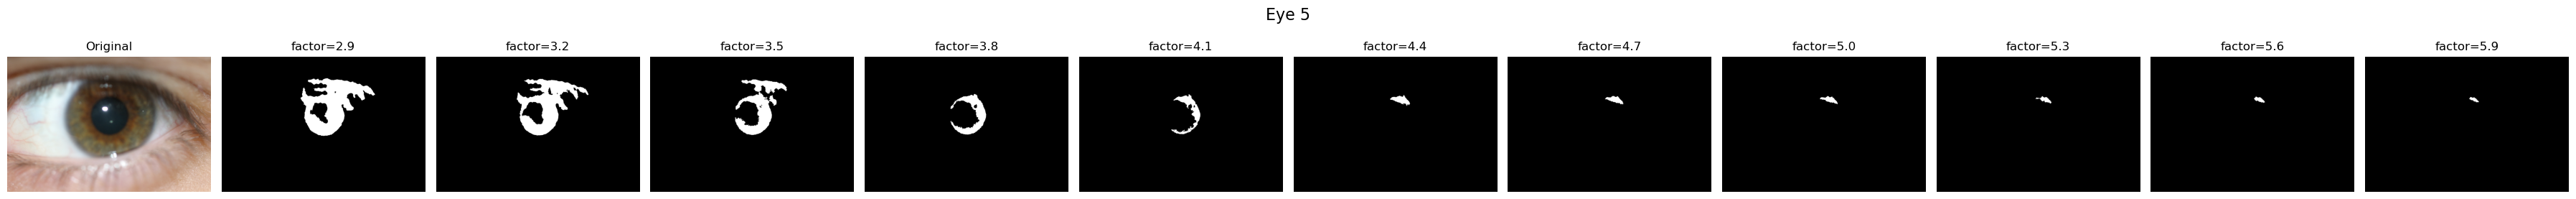

In [45]:
factors = [i/10 for i in range(29, 60, 3)]

for idx, path in enumerate(image_paths, 1):
    if not Path(path).exists():
        print(f"Warning: {path} not found – skipping")
        continue

    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = grayscale(rgb)

    num_pictures = len(factors) + 1
    fig, axes = plt.subplots(1, num_pictures, figsize=(3 * num_pictures, 3))
    axes[0].imshow(rgb); axes[0].set_title("Original"); axes[0].axis("off")

    for j, f in enumerate(factors, 1):
        mask = binarize(gray, f)
        mask_opening = opening(mask, np.ones((5, 5)))
        mask_opening_closing = closing(mask_opening, np.ones((5, 5)))
        mask_opening_closing_llc = largest_connected_component(mask_opening_closing)

        axes[j].imshow(mask_opening_closing_llc, cmap='gray')
        axes[j].set_title(f"factor={f}")
        axes[j].axis("off")

    fig.suptitle(f"Eye {idx}", fontsize=16)
    plt.tight_layout()
    plt.show()